<a href="https://colab.research.google.com/github/ChristianParsons98/PG_Lab_Code/blob/main/XRD_Profex_Plotting_Phillip_Na3PS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
pip install adjustText

In [30]:
%matplotlib inline
from sympy import init_printing
init_printing(use_latex=True)
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import io
import re
from scipy.signal import savgol_filter
from adjustText import adjust_text

# This document is to read in and plot XRD Fitting from Profex and assign hkl peak labels

#This document is for LLYTO Anatase

#You need to include two files:
# The Result file from Profex is: /content/LLYTO-8-22-2025.dia
# The list of peaks which can be exported from Profex: /content/LLYTO_A_PeakList.csv

#You need to choose a minimum intensity for your peak labels. I would recommend 0.01 at the lowest.

In [31]:
# User Chosen Variables:

#This is the minimum intensity peak which will be labeled.
hkl_Cutoff = 0.1

#Profex Results file path
PR_path='/content/Na3PS4-10.dia'

#Peak Position file path
PP_path='/content/Na3PS4-10-Peak List.csv'

In [32]:
def load_peak_list(path: str) -> pd.DataFrame:
    """
    Load and clean the 'Peak List' CSV exported with outer quotes, doubled inner quotes,
    and space-separated fields that include a file path with spaces.

    Strategy
    --------
    1) Strip outer quotes per line and un-escape doubled quotes ("").
    2) For each data row, split from the RIGHT into 11 splits (=> 12 fields total),
       so the leftmost 'File' column (with spaces) remains intact.
    3) Assign canonical column names and coerce numerics.
    """
    # The expected columns in the file
    columns = [
        "File", "Phase", "h", "k", "l", "Angle (2t)", "d (nm)",
        "Intensity (deg*cts)", "Rel. intensity (%)", "Texture",
        "B1 (1/nm)", "B2 (1/nm)"
    ]

    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        # Read and ignore header line (we'll use our known columns list)
        header_line = f.readline()

        for line in f:
            line = line.rstrip("\n").strip()
            if not line:
                continue

            # Remove one pair of outer quotes if present
            if line.startswith('"') and line.endswith('"'):
                line = line[1:-1]

            # Un-escape doubled quotes -> actual quotes
            line = line.replace('""', '"')

            # Split from the RIGHT into 11 splits => 12 fields total.
            # This preserves the full left-side file path (with spaces).
            parts = line.rsplit(' ', maxsplit=11)

            # Fallback: compress multiple spaces, try again
            if len(parts) != 12:
                compact = re.sub(r"\s+", " ", line)
                parts = compact.rsplit(' ', maxsplit=11)

            if len(parts) == 12:
                rows.append(parts)
            else:
                # Skip badly formed lines (or log if desired)
                # print(f"Skipping malformed line: {line[:120]}...")
                continue

    df = pd.DataFrame(rows, columns=columns)

    # Clean stray quotes in 'Phase' (if any)
    if "Phase" in df.columns and df["Phase"].dtype == object:
        df["Phase"] = df["Phase"].str.replace('"', '', regex=False).str.strip()

    # Coerce numeric columns
    numeric_cols = [
        "h", "k", "l",
        "Angle (2t)", "d (nm)", "Intensity (deg*cts)",
        "Rel. intensity (%)", "Texture", "B1 (1/nm)", "B2 (1/nm)"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

peak_df = load_peak_list(PP_path)

#Filter out the amorphous background peak
peak_df = peak_df[~peak_df["Phase"].str.lower().str.contains("amorphous", na=False)]

peak_df["hkl"] = (
    "("
    + peak_df["h"].astype(int).astype(str)
    + " "
    + peak_df["k"].astype(int).astype(str)
    + " "
    + peak_df["l"].astype(int).astype(str)
    + ")"
)



#Import the fit data from Profex
df_fit = pd.read_csv(PR_path, delim_whitespace=True, skiprows=1, header=None)

/tmp/ipython-input-2409440943.py:89: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_fit = pd.read_csv(PR_path, delim_whitespace=True, skiprows=1, header=None)


<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-904701029.py:14: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("Angle 2$\Theta$")


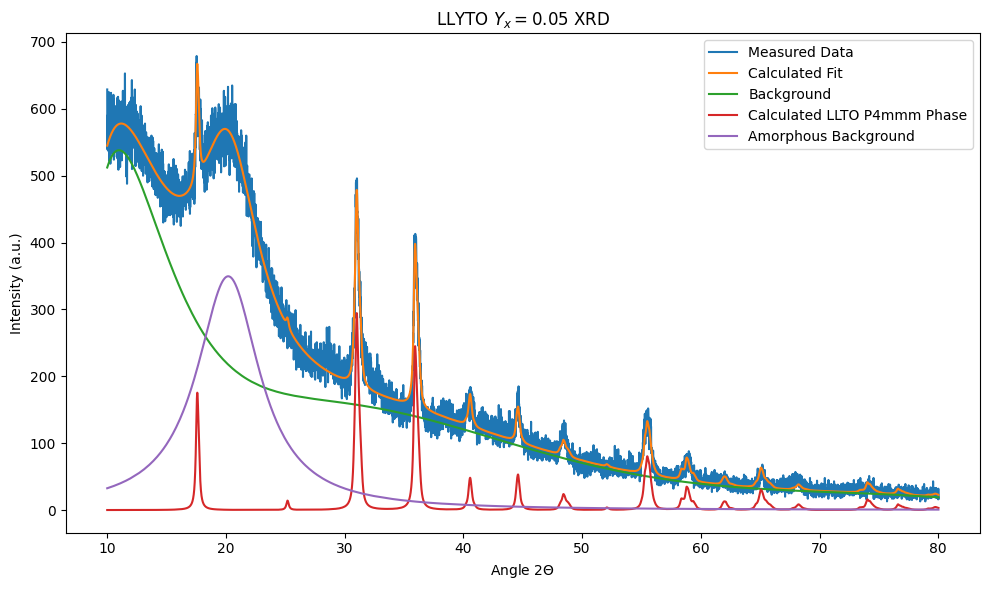

In [35]:
#Showing the data with the background

plt.figure(figsize=(10, 6))

#Manually add the column labels. The first column in the .dia file is the 2 Theta Diffraction Angle.
labels=['Measured Data','Calculated Fit', 'Background','Calculated LLTO P4mmm Phase','Amorphous Background']

#First Column is the 2 theta angle which gets plotted to the x-axis
x = df_fit.iloc[:, 0]
#Iterate over the other columns, manually labeling with the labels list.
for i in range(1, df_fit.shape[1]):
    plt.plot(x, df_fit.iloc[:, i], label=labels[i-1])

plt.xlabel("Angle 2$\Theta$")
plt.ylabel("Intensity (a.u.)")
plt.title("LLYTO $Y_x=0.05$ XRD")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.savefig('LLYTO_Anatase_Yx0p05_XRD_Fit.png', dpi=900)
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\T'
<>:36: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3071737597.py:36: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("Angle 2$\Theta$")


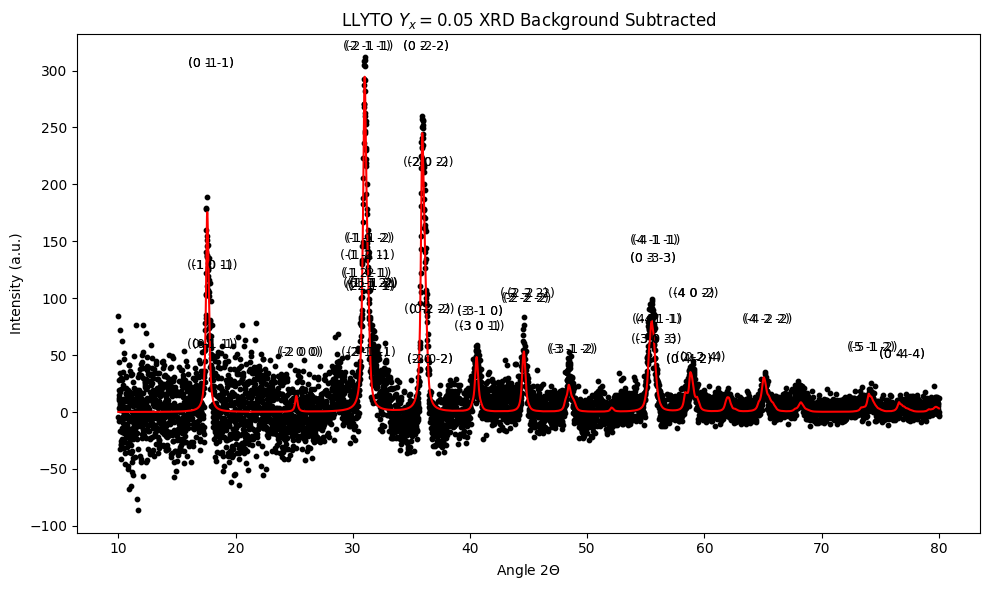

In [36]:
# Plot the background subtracted data with the hkl values labeled.
plt.figure(figsize=(10, 6))

#Background Subtraction
# We want to plot the background subtracted data and the calculated spectrum
BG_sub_data = df_fit.iloc[:, 1] - df_fit.iloc[:, 3] - df_fit.iloc[:, 5]
Calc = df_fit.iloc[:, 4]
# Diffraction angle 2 theta
x = df_fit.iloc[:, 0]

#This is where we will insert the hkl values - above the highest peak
y_top = Calc.max()

#And just a helper to find the max of the plot to prevent the hkl from being off the plot.
Plot_max = max(Calc.max(),BG_sub_data.max())

#Iterate over the other columns, manually labeling with the labels list.
plt.scatter(x, BG_sub_data,label='Background Subtracted Measured Spectrum',s=10,c='k')
plt.plot(x,Calc,label='Calculated LLTO P4mmm Phase',color='red')

#Define the max relative intensity to scale locations of hkl labels
Max_RelI= max(peak_df['Rel. intensity (%)'])

for _, row in peak_df.iterrows():
    angle = row["Angle (2t)"]
    hkl_label = row["hkl"]
    Rel_Int = row["Rel. intensity (%)"]

    if float(Rel_Int) > hkl_Cutoff:
      plt.annotate(hkl_label, xy=(float(angle), min(Plot_max*.96,float(Rel_Int)/float(Max_RelI)*y_top*1.8)),
                  xytext=(0, 15), textcoords='offset points',
                  ha='center', fontsize=9)
    else:
      continue

plt.xlabel("Angle 2$\Theta$")
plt.ylabel("Intensity (a.u.)")
plt.title("LLYTO $Y_x=0.05$ XRD Background Subtracted")
#plt.legend()
#plt.grid(True)
plt.tight_layout()
#plt.savefig('LLYTO_Y0p05_BGSub_hkl.png', dpi=900)
plt.show()

0 [ 0.82612214 -0.89577732]
1 [ 0.29852667 -0.22020701]
2 [-0.74576529 -0.19485228]
3 [0.02687648 0.23481508]
4 [ 0.4578194  -0.16237805]
5 [ 0.48099527 -0.24464588]
6 [-0.62461761  0.07976951]
7 [ 0.08610406 -0.37993593]
8 [-0.60714616  0.05994432]
9 [ 0.32084052 -0.6037754 ]
10 [-0.83412826 -0.33507163]
11 [-0.70315276  0.63145538]
16 [-0.89778646 -0.41310368]
17 [-0.94902066  0.49180193]
12 [0.54778748 0.04997888]
13 [0.20198024 0.82847138]
14 [0.80071192 0.38880994]
15 [-0.11137811 -0.76416888]
18 [-0.07044293 -0.27220837]
19 [-0.60730493 -0.66468212]
20 [-0.06722232 -0.18884621]
21 [-0.49662675 -0.92553836]
22 [-0.14984509 -0.56524469]
23 [ 0.35144462 -0.70089985]
24 [0.8533751  0.61512209]
25 [0.93960624 0.57136578]
26 [0.0792798  0.89491386]
27 [-0.59862241  0.91501053]
28 [-0.43376768 -0.19163672]
29 [-0.77730924  0.82461285]
30 [-0.47390211 -0.59878261]
31 [-0.8133756   0.22847094]
34 [-0.0613386   0.88305002]
35 [-0.01973074  0.41088564]
32 [-0.40190023  0.82985731]
33 [ 0.32

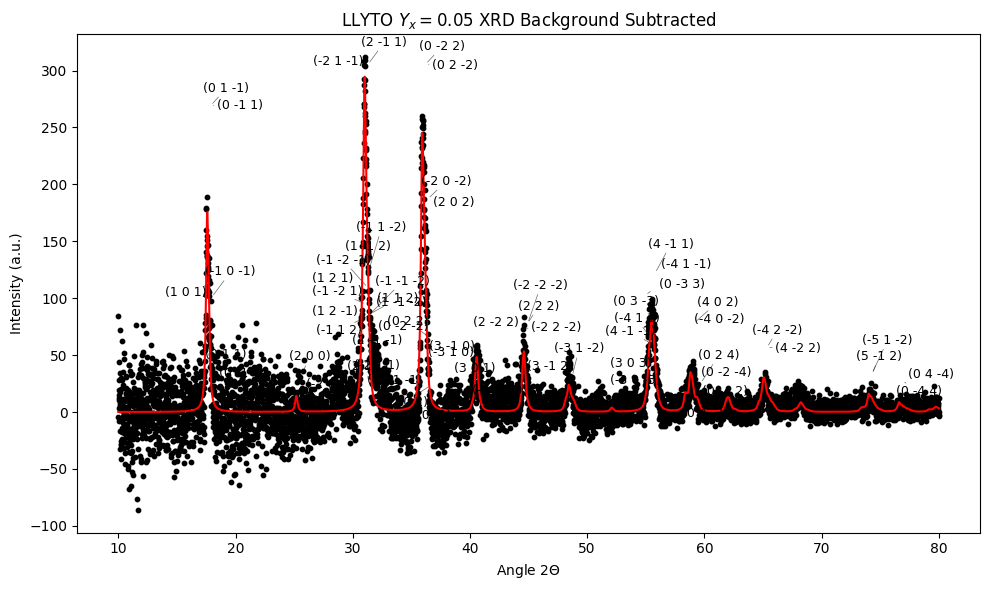

In [40]:
# Plot the background subtracted data with the hkl values labeled.
plt.figure(figsize=(10, 6))

# Background Subtraction
BG_sub_data = df_fit.iloc[:, 1] - df_fit.iloc[:, 3] - df_fit.iloc[:, 5]
Calc = df_fit.iloc[:, 4]
# Diffraction angle 2 theta
x = df_fit.iloc[:, 0]

# This is where we will insert the hkl values - above the highest peak
y_top = Calc.max()

# And just a helper to find the max of the plot to prevent the hkl from being off the plot.
Plot_max = max(Calc.max(), BG_sub_data.max())

# Plot data
plt.scatter(x, BG_sub_data, label='Background Subtracted Measured Spectrum', s=10, c='k')
plt.plot(x, Calc, label='Calculated LLTO P4mmm Phase', color='red')

# Define the max relative intensity to scale locations of hkl labels
Max_RelI = peak_df['Rel. intensity (%)'].max()

# --- Build text objects, then adjust them (vertical moves only) ---
texts = []
for _, row in peak_df.iterrows():
    angle = float(row["Angle (2t)"])
    hkl_label = row["hkl"]
    Rel_Int = float(row["Rel. intensity (%)"])

    if Rel_Int <= hkl_Cutoff:
        continue

    # same y as your original annotate
    y_pos = min(Plot_max * 0.98, (Rel_Int / Max_RelI) * y_top * 1.7)

    # create text at (x, y); we’ll let adjust_text move it along y only
    t = plt.text(angle, y_pos, hkl_label, ha='center', fontsize=9)
    texts.append(t)

# Nudge labels to avoid overlap, restricting movement to y only
adjust_text(
    texts,
    only_move={'points': 'y', 'text': 'y'},
    # arrows optional; comment out if you don't want leader lines
    arrowprops=dict(arrowstyle='-', lw=0.5, alpha=0.6)
)

plt.xlabel("Angle 2$\\Theta$")
plt.ylabel("Intensity (a.u.)")
plt.title("LLYTO $Y_x=0.05$ XRD Background Subtracted")
# plt.legend()
# plt.grid(True)
plt.tight_layout()
# plt.savefig('LLYTO_Y0p05_BGSub_hkl.png', dpi=900)
plt.show()